In [3]:
# Imports
import os
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from operator import itemgetter

In [5]:
# Setting Directory to the LCR Data Set.
# Then, sets up a Data Frame of the unfiltered data.
# Finally, prints out the unfiltered data as a table.
os.getcwd()
os.chdir('/Users/glatiolait/Documents/LCR/LCR_files+scripts')
table = "new_db_Feb2023.csv"
opened = open(table,"r")
readed = pd.read_csv(table, sep=",")
tablelist = list(csv.reader(readed))
data_array = np.array(readed)
df = pd.DataFrame(data_array)
df

,0,1,2,3,4,5,6,7,8,9
0,0,4FGL J0001.2-0747,daily,239587201,239846401,0.0,0.0,2.18,0.0,2.44
1,1,4FGL J0001.5+2113,daily,239587201,239846401,NaN,NaN,NaN,0.0,0.52
2,2,4FGL J0003.3-1928,daily,239587201,239846401,NaN,NaN,NaN,102.0,-0.0
3,3,4FGL J0004.3+4614,daily,239587201,239846401,NaN,NaN,NaN,102.0,-0.0
4,4,4FGL J0004.4-4737,daily,239587201,239846401,0.0,0.0,2.97,0.0,8.93
...,...,...,...,...,...,...,...,...,...,...
4132745,4132745,4FGL J2358.0-4601,weekly,698630401,699235201,NaN,NaN,NaN,NaN,NaN
4132746,4132746,4FGL J2358.3-1021,weekly,698630401,699235201,NaN,NaN,NaN,NaN,NaN
4132747,4132747,4FGL J2358.3+3830,weekly,698630401,699235201,NaN,NaN,NaN,NaN,NaN
4132748,4132748,4FGL J2359.0+3922,weekly,698630401,699235201,NaN,NaN,NaN,NaN,NaN


In [24]:
# Prompts the User for a selection of Cadence values. 
# I accounted for possible misspellings regarding capitalization.
# If the cadence value inputted is incorrect, then an error is displayed.
# The function then takes the inputted cadence string, and filters the DataFrame table with that.

cadence = input("Input Cadence Selection. (daily, weekly, or monthly) Case Sensitive.")
if cadence not in ['daily', 'Daily', 'weekly', 'Weekly', 'monthly', 'Monthly']:
    print("Error. Invalid option")

# This section takes the user input for cadence, and then outputs a data set for a random source within that cadence value.
# The randomsource variable takes a random name from the list, so some sources may be weighted far more heavily than others.
# I am not sure if the randomness is necessary, but it allowed an easy way to test multiple graphs.
# I have also included a default source name to check against consistently.

randomsource = np.random.choice(data_array[:,1])
randomsource = '4FGL J0001.2-0747'


# Prints out which source was randomly picked. Not necessary for using the default option.
print(randomsource)

# Filters the catalogue to only randomsource, cadence, sigma values larger than 4, and photon flux values greater than their error margins.
sortedsource = np.where((data_array[:,1] == randomsource) & (data_array[:,2]==cadence) & (data_array[:,-1] >= 4) & (data_array[:,6] < data_array[:,5]))

# Displays the dataframe to ensure everything is working as intended. Will omit in the future.
pd.DataFrame(data_array[sortedsource])

4FGL J0001.2-0747


,0,1,2,3,4,5,6,7,8,9
0,42701,4FGL J0001.2-0747,monthly,242179201,244771201,0.0,0.0,1.87,0.0,16.71
1,89976,4FGL J0001.2-0747,monthly,247363201,249955201,0.0,0.0,1.19,0.0,5.91
2,228751,4FGL J0001.2-0747,monthly,262915201,265507201,0.0,0.0,2.15,0.0,5.64
3,253151,4FGL J0001.2-0747,monthly,265507201,268099201,0.0,0.0,2.18,0.0,4.08
4,276026,4FGL J0001.2-0747,monthly,268099201,270691201,0.0,0.0,2.26,0.0,15.06
...,...,...,...,...,...,...,...,...,...,...
60,3213176,4FGL J0001.2-0747,monthly,594691201,597283201,0.0,0.0,3.01,102.0,18.79
61,3562401,4FGL J0001.2-0747,monthly,633571201,636163201,0.0,0.0,0.91,0.0,19.27
62,3818601,4FGL J0001.2-0747,monthly,662083201,664675201,0.0,0.0,2.02,0.0,6.1
63,3936026,4FGL J0001.2-0747,monthly,675043201,677635201,0.0,0.0,1.2,0.0,10.31


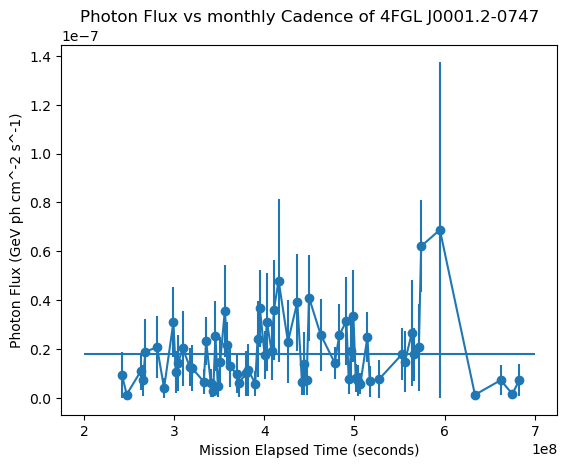

In [25]:
# This block of code is where a majority of the plots will go.

GraphTest = (data_array[sortedsource])
Plot = pd.DataFrame(GraphTest)
ysize = Plot.size
x = pd.DataFrame(GraphTest[:,3]/(60*60*24*365))

# The title displays the name of the graph, with references that will vary the cadence and name of the source.
plt.title("Photon Flux vs " +GraphTest[0,2]+ " Cadence of "+GraphTest[0,1])

# The x-axis displays the time elapsed in seconds. I would like to convert this to be a range of years.
plt.xlabel("Mission Elapsed Time (seconds)")

# The y-axis displays the Photon Flux. I don't believe the numerical labels are correct, but the shape of the graph appears to be correct.
plt.ylabel("Photon Flux (GeV ph cm^-2 s^-1)")

# This is the actual function that plots the data. At the moment, it plots column 3 (Time) vs column 5 (Photon Flux)
#Graph = plt.plot(Plot[3],Plot[5])
plt.errorbar(Plot[3],Plot[5],yerr=Plot[6],fmt = 'o-')
plt.hlines(np.mean(GraphTest[:,5]),2e8,7e8)

In [26]:
# This is the setup of the main loop to analyze one source.
# This loop can be modified to display either the factors of average flux at any time bin, or can be used to display a binary array
# Of "If above average flux, value is 1. If below, value is 0."
# At the moment, the loop will display an array of the factors at each time bin.
base = np.zeros(len(GraphTest))
averageflux = np.mean(GraphTest[:,5])
factors = GraphTest[:,5]/averageflux
emptyarray = [0]
j = 0
k = 0
emptyarray=[0]
while j < len(base):
    if (factors[j] < 1) and (factors[j-1]) > 0:
        emptyarray.append(0)
        k+=1
    elif factors[j] > 0:
        emptyarray[k] = 1
    j+=1

print(emptyarray)

[0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0]


In [27]:
# This is the big loop that processes the entire database. It performs an evaluation of the flux for each source at each time bin.
# The inner loop creates a time-domain array of how far above or below the average flux that the flux at each time bin.
# It then takes this array, and adds it to a list of each source name. Associated with each source is also the average flux, which was used in reference to the factor array.
# This is repeated for all sources, which at the moment is about 1500+.
# The name of the final DataFrame that contains all of this info is a placeholder. I will most likely change it when the time comes to present the code.
names = df.drop_duplicates(subset=[1], inplace=False)[1]
Esras = []
sourcenumber = 0
while sourcenumber < len(names):
    
    source_array = (data_array[np.where((data_array[:,1] == names[sourcenumber]) & (data_array[:,2]==cadence) & (data_array[:,-1] >= 4) & (data_array[:,6] < data_array[:,5]))])
    base = np.zeros(len(source_array))
    averageflux = np.mean(source_array[:,5])
    factors = source_array[:,5]/averageflux
    emptyarray = [0]
    j = 0
    k = 0
    
    while j < len(base):
        if (factors[j] < 1) and (factors[j-1]) > 0:
            emptyarray.append(0)
            k+=1   
        elif factors[j] > 0:
            emptyarray[k] = 1
        j+=1
    Esras.append((names[sourcenumber],emptyarray,averageflux))
    sourcenumber += 1
pd.DataFrame(Esras)

/opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:131: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret / rcount


,0,1,2
0,4FGL J0001.2-0747,"[0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, ...",1.817077e-08
1,4FGL J0001.5+2113,"[0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",9.248067e-08
2,4FGL J0003.3-1928,"[1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, ...",1.543125e-08
3,4FGL J0004.3+4614,"[0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, ...",3.332200e-08
4,4FGL J0004.4-4737,"[0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, ...",2.439535e-08
...,...,...,...
1520,4FGL J2358.0-4601,"[1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, ...",2.493000e-08
1521,4FGL J2358.3-1021,"[0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, ...",4.268397e-08
1522,4FGL J2358.3+3830,"[0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, ...",1.828971e-08
1523,4FGL J2359.0+3922,"[0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, ...",2.407656e-08


In [28]:
Esras=pd.DataFrame(Esras).rename(columns={0: 'source_name', 1: 'flux_values',2: 'average_flux'})


In [29]:
Esras.to_csv(r'/Users/glatiolait/Documents/Exports/monthly_fluxFeb2023')